In [1]:
import pandas as pd
import numpy as np
from nltk.classify import NaiveBayesClassifier as nbc
from collections import defaultdict, Counter
import nltk
import gensim
import operator
import os
# for 'kernel crashes' using xgboost...
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import spacy
import re
import matplotlib.pyplot as plt
import sys
import warnings
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, average_precision_score, make_scorer, f1_score
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import label_binarize, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn import svm
import pickle
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
import string
from gensim import corpora
punctuations = string.punctuation
stopwords = stopwords.words('english')
!python -m spacy download en 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import one_hot, text_to_word_sequence, hashing_trick, Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from xgboost import XGBClassifier
import dask.dataframe as dd
import dask.array as da


    Linking successful
    /Users/jonathan/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
    /Users/jonathan/anaconda3/lib/python3.7/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Using TensorFlow backend.


In [2]:
# read in the raw training data
train_raw = pd.read_csv('data/train-raw.tsv', sep='\t')
train_raw_x = train_raw['Text']
train_raw_y = train_raw['Location']
# read in the dev data
dev_test = pd.read_csv('data/dev-raw.tsv', sep='\t', skiprows=1, header=None)
dev_test.columns = ['ID', 'Location', 'Text']
dev_test_x = dev_test['Text']
dev_test_y = dev_test['Location']
# read in the test data
final_test = pd.read_csv('data/test-raw.tsv', sep='\t', skiprows=1, header=None)
final_test.columns = ['ID', 'Location', 'Text']
final_test_x = final_test['Text']
final_test_y = final_test['Location']

# perform preprocessing step including removing non-alphanumeric characters, converting all words into their 'base' form
# (using stemming), and conveting all words to lowercase.
trim = PorterStemmer()
train_cleaned_x = train_raw_x.apply(lambda x: " ".join([trim.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords]).lower())
dev_cleaned_x = dev_test_x.apply(lambda x: " ".join([trim.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords]).lower())
test_cleaned_x = final_test_x.apply(lambda x: " ".join([trim.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords]).lower())
# create a tf-idf vectorizer (these parameters have been set based on testing over a substantial period of time)
# we will use both unigrams, bigrams and trigrams in this model/
vectorizer = TfidfVectorizer(min_df= 10,max_df=0.5, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 3))


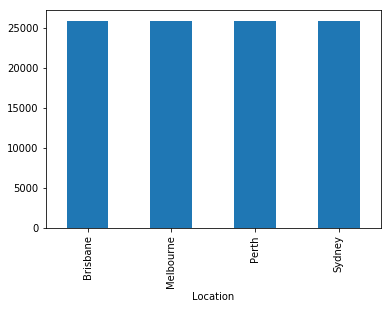

In [4]:
# this shows that the class distribution for each city is invariant.
train_raw.groupby('Location').Location.count().plot.bar(ylim=0)


In [5]:
# try the candidate models on the preprocessed data given to us.
df100 = dd.read_csv('data/train-top100.csv')
train_100 = dd.read_csv('data/train-top100.csv')
train_100_x = train_100.loc[:, train_100.columns != 'Location']
train_100_y = train_100.loc[:, 'Location']
dev_100 = dd.read_csv('data/dev-top100.csv')
dev_100_x = dev_100.loc[:, dev_100.columns != 'Location']
dev_100_y = dev_100.loc[:, 'Location']
model_list = [RandomForestClassifier(), GradientBoostingClassifier(), MultinomialNB(), LinearSVC(), 
             KNeighborsClassifier(n_neighbors=4), DecisionTreeClassifier(), XGBClassifier()]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for mod in model_list:
        name = mod.__str__().split('(')[0]
        mod.fit(train_100_x, train_100_y)
        print("model is: {0} and accuracy is: {1} ".format(name, accuracy_score(mod.predict(dev_100_x), dev_100_y)))
        sys.stdout.flush()

model is: RandomForestClassifier and accuracy is: 0.30469503698145567 
model is: GradientBoostingClassifier and accuracy is: 0.3082591917676064 
model is: MultinomialNB and accuracy is: 0.30732125629756674 
model is: LinearSVC and accuracy is: 0.26246114267338405 
model is: KNeighborsClassifier and accuracy is: 0.24975881659341836 
model is: DecisionTreeClassifier and accuracy is: 0.3046682388251688 


In [23]:
# iterate through a list of candidate classifiers using their (mostly) default settings.
# this will take a long time to do. The output of this step was used to help select from these initial candidate models.
model_list = [RandomForestClassifier(), GradientBoostingClassifier(), MultinomialNB(), LinearSVC(), 
             KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(), XGBClassifier()]
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for mod in model_list:
        name = mod.__str__().split('(')[0]
        pipeline_vect = Pipeline([('vect', vectorizer),
                     ('mod', mod)])
        preds_vect = pipeline_vect.fit(train_cleaned_x, train_raw_y).predict(dev_cleaned_x)
        print("model is: {0} and accuracy is: {1} ".format(name, accuracy_score(preds_vect, dev_test_y)))

# n.b. that our vectorizer performs better than the preprocessed data given in the inital dataset (see performance of
# the models above)

model is: RandomForestClassifier and accuracy is: 0.3231635388739946 
model is: GradientBoostingClassifier and accuracy is: 0.30498659517426274 
model is: MultinomialNB and accuracy is: 0.32756032171581767 
model is: LinearSVC and accuracy is: 0.3253619302949062 
model is: KNeighborsClassifier and accuracy is: 0.27249329758713137 
model is: DecisionTreeClassifier and accuracy is: 0.31654155495978553 
model is: XGBClassifier and accuracy is: 0.303887399463807 


In [43]:
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 200, 10)]
max_depth.append(None)
min_samples_split = [4, 7, 15, 23]
min_samples_leaf = [3, 5, 10, 15]
# grid of different feature values used to help fine-tune the hyperparameters.
random_grid = {
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf}
rfpipe = Pipeline([ ('vect', vectorizer), ('rf', RandomForestClassifier())])

rf_random = RandomizedSearchCV(estimator=rfpipe, param_distributions= random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_fitted_model = rf_random.fit(train_cleaned_x, train_raw_y)
preds_rf_opt = rf_fitted_model.predict(dev_cleaned_x)

print(accuracy_score(preds_rf_opt, dev_test_y))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.0min remaining:   18.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.3min finished
/Users/jonathan/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.31450402144772116


In [ ]:
# this code is quite slow - it is used for hyperparameter tuning for the SVC, with no benefit gleaned.

SVCpipe = Pipeline([ ('vect', vectorizer), ('SVC', LinearSVC())])

parameters = {'SVC__C':np.arange(0.01,100,10)}
linearSVC = RandomizedSearchCV(SVCpipe,parameters,cv=3,return_train_score=True, n_jobs=-1, verbose=2)
preds_svc_opt = linearSVC.fit(train_cleaned_x, train_raw_y).predict(dev_cleaned_x)
print(accuracy_score(preds_svc_opt, dev_test_y))


In [9]:
# this 'out-of-the-box' MNB model was used in the kaggle predictions.

pipeline_vect = Pipeline([('vect', vectorizer),
                     ('clf_nb', MultinomialNB())])
preds_vect_nb = pipeline_vect.fit(train_cleaned_x, train_raw_y)
dev_preds = preds_vect_nb.predict(dev_cleaned_x)

print(accuracy_score(dev_preds, dev_test_y))


0.32756032171581767


In [67]:
# initial hyperparameter tuning of this model didn't yield a better accuracy than above:

pipeline = Pipeline([('vec', vectorizer),
             ('clf',   MultinomialNB())])
parameters = {  
'vec__max_df': (0.3, 0.5, 0.7, 1.0),  
'vec__max_features': (None, 1500, 1700),  
'vec__min_df': (2, 3, 5, 7, 10, 20),  
'vec__norm' : ('l1', 'l2'),
'vec__ngram_range': ((1, 1), (1, 2), (1,3), (1,4)),
'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}  

grid_search = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=2, cv=5)  
fitted_grid = grid_search.fit(train_cleaned_x, train_raw_y)
preds_vect = fitted_grid.predict(dev_cleaned_x)
print(accuracy_score(preds_vect, dev_test_y))
best_parameters = fitted_grid.best_estimator_.get_params()  

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


0.32734584450402143


In [ ]:
# hyperparameter tuning using a more-exhausting gridsearch strategy on the gradient boosting classifer.
# this step can take up to an hour to process.

gradpipe = Pipeline([('vect', vectorizer), ('clf', GradientBoostingClassifier())])
params = {'clf__n_estimators': [500, 700], 'clf__max_depth': [8, 20],
          'clf__learning_rate': [0.01, 0.001]}

gridboost = GridSearchCV(gradpipe,params,cv=2, return_train_score=True, n_jobs=-1, verbose=2)
fitted_grid = gridboost.fit(train_cleaned_x, train_raw_y).predict(dev_cleaned_x)
preds_vect = fitted_grid.predict(dev_cleaned_x)
print(accuracy_score(preds_vect, dev_test_y))
best_parameters = fitted_grid.best_estimator_.get_params()  

In [62]:
# the confusion matrix shows that there is little difference in the performance of the gradient boosting classifier
# on all four cities.

print(classification_report(dev_test_y,preds_vect))
print(confusion_matrix(dev_test_y, preds_vect))

              precision    recall  f1-score   support

    Brisbane       0.32      0.34      0.33      9324
   Melbourne       0.33      0.34      0.33      9325
       Perth       0.34      0.28      0.31      9325
      Sydney       0.32      0.35      0.33      9326

   micro avg       0.33      0.33      0.33     37300
   macro avg       0.33      0.33      0.33     37300
weighted avg       0.33      0.33      0.33     37300

[[3212 2080 1739 2293]
 [2154 3159 1716 2296]
 [2319 2198 2624 2184]
 [2290 2112 1701 3223]]


In [ ]:
# Decision Tree classifier hyper-parameteter tuning with five-fold cross-validation.
parameters={'min_samples_split' : np.arange(10,700,20),'max_depth': np.arange(1,100,2), 'criterion': ('gini', 'entropy')}

dctpipe = make_pipeline((vectorizer), GridSearchCV(DecisionTreeClassifier(), n_jobs=-1, verbose=2, cv=5, param_grid=parameters, refit=True))


optimised_dtc = dctpipe.fit(train_cleaned_x ,train_raw_y).predict(dev_cleaned_x)
pprint(accuracy_score(optimised_dtc, ytest))


In [5]:
# This is the initial MLP model with architecture FC layer (Dense) of 100 neurons, then a final four neuron layer
# for each city/class. 

sentences = train_cleaned_x.values
y = train_raw_y.values

# convert this into 'one-hot encoded' form (necessary for keras models)
onehot_y = pd.get_dummies(y)
target_labels_y = onehot_y.columns
y_mat = onehot_y.as_matrix()

# split the training data into train/test splits
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y_mat, test_size=0.25, random_state=1000)

# tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)

# ensure each data point is of length 30.
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_train = pad_sequences(X_train, padding='post', maxlen=30)
X_test = pad_sequences(X_test, padding='post', maxlen=30)


vocab_size = len(tokenizer.word_index) + 1  

# this is the model used for the first MLP
model = Sequential()
model.add(Dense(100, activation='relu'))
# perform dropout to try and prevent over-fitting.
model.add(Dropout(0.2))
model.add(Dense(4))
model.add(Activation('softmax'))

# ensure the 'categorical crossentropy' is used as this is a multi-class problem.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit the data, validate against the held-out training data
fitted_model = model.fit(np.array(X_train), np.array(y_train),
                    epochs=20,
                    verbose=True,
                    validation_data=(np.array(X_test), np.array(y_test)),
                    batch_size=20)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))

# save the model
model.save('model_keras_updated.h5')



/Users/jonathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 77520 samples, validate on 25840 samples
Epoch 1/15
77520/77520 [==============================] - 7s 92us/step - loss: 11.8668 - acc: 0.2515 - val_loss: 11.4927 - val_acc: 0.2547
Epoch 2/15
77520/77520 [==============================] - 6s 82us/step - loss: 11.8664 - acc: 0.2519 - val_loss: 11.5508 - val_acc: 0.2521
Epoch 3/15
77520/77520 [==============================] - 6s 81us/step - loss: 11.8993 - acc: 0.2505 - val_loss: 11.6830 - val_acc: 0.2493
Epoch 4/15
77520/77520 [==============================] - 7s 90us/step - loss: 11.9375 - acc: 0.2492 - val_loss: 11.6371 - val_acc: 0.2504
Epoch 5/15
77520/77520 [==============================] - 7s 86us/step - loss: 11.9073 - acc: 0.2508 - val_loss: 11.6504 - val_acc: 0.2507
Epoch 6/15
77520/775

In [ ]:
# this cell contains an alternative model used for the MLP used in the kaggle predictions step.

sentences = train_cleaned_x.values
y = train_raw_y.values

onehot_y = pd.get_dummies(y)
target_labels_y = onehot_y.columns
y_mat = onehot_y.as_matrix()


sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y_mat, test_size=0.20, random_state=1000)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_train = pad_sequences(X_train, padding='post', maxlen=20)
X_test = pad_sequences(X_test, padding='post', maxlen=20)


vocab_size = len(tokenizer.word_index) + 1  

embedding_dim = 50

# improved architecture uses a preprocessed embedding vector (of dimension size 50)
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=20))
model.add(layers.GlobalMaxPool1D())
model.add(Dense(128, input_shape = (vocab_size,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4))
model.add(Activation('softmax'))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(np.array(X_train), np.array(y_train),
                    epochs=11,
                    verbose=True,
                    validation_data=(np.array(X_test), np.array(y_test)),
                    batch_size=20)
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

model.save('model_keras_alt.h5')



In [4]:
np.array(X_test).shape, X_train.shape

((20672, 20), (82688, 20))

In [15]:
sentences = train_cleaned_x.values
y = train_raw_y.values

onehot_y = pd.get_dummies(y)
target_labels_y = onehot_y.columns
y_mat = onehot_y.as_matrix()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
# load the initial model
fin_mod_mlp = load_model('model_keras_updated.h5')
# load the alternative mlp model
fin_mod_alt = load_model('model_keras_alt.h5')

final_sentences = test_cleaned_x.values
final_preds_seq = tokenizer.texts_to_sequences(final_sentences)
final_preds_seq_alt =  pad_sequences(final_preds_seq, padding='post', maxlen=20)
final_preds_seq =  pad_sequences(final_preds_seq, padding='post', maxlen=30)

# final predictions on the test data:
# first model
preds_fin_mlp = fin_mod_mlp.predict(final_preds_seq)
# second model
preds_fin_alt = fin_mod_alt.predict(final_preds_seq_alt)

dev_sentences = dev_cleaned_x.values
dev_test = tokenizer.texts_to_sequences(dev_sentences)
# pad out the sentence to ensure they are of the correct length.
dev_test_alt = pad_sequences(dev_test, padding='post', maxlen=20)
# minor difference used for alternative mlp (different sentence length)
dev_test =  pad_sequences(dev_test, padding='post', maxlen=30)

# predictions on the dev data for both models
preds_dev_mlp = fin_mod_mlp.predict(dev_test)
preds_dev_mlp_alt = fin_mod_alt.predict(dev_test_alt)

# obtain the dev accuracy for first mod
samples = dev_test_x.shape[0]
true=0
for c,d in zip(preds_dev_mlp, dev_test_y):
    if np.argmax(c)==np.argmax(d):
        true+=1
acc_mlp = true/samples

# obtain the dev accuracy for alternative mlp model
true_alt=0
for c,d in zip(preds_dev_mlp_alt, dev_test_y):
    if np.argmax(c)==np.argmax(d):
        true_alt+=1
acc_alt = true_alt/samples

print("dev accuracy for first model is: ", acc_mlp)
print("dev accuracy for second model is: ", acc_alt)

# note the huge difference between training and dev accuracy below for the second model. this model has *hugely
# overfit the data (had a training accuracy of 98%, dev accuracy of 23%, which is worse than a zeroR baseline.)

# the first model gave better test predictions as well.

/Users/jonathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


dev accuracy for first model is:  0.5135656836461125
dev accuracy for second model is:  0.23292225201072386


In [17]:
# function to generate the keras predictions back into correct form for kaggle predictions.
preds_fin_one = np.zeros(shape=preds_fin_mlp.shape)

# obtain the largest probability for each data point:
for row, col in enumerate(preds_fin_mlp):
    p = np.argmax(col)
    preds_fin_one[row, p] = 1
    
# create a list to hold the final predictions:
preds_map = [None for _ in range(preds_fin_one.shape[0])]

# Change the 'ones' into strings:
for x in range(0, preds_fin_one.shape[0]):
    for y in range(0, preds_fin_one.shape[1]):
        if preds_fin_one[x, 0] == 1: 
            preds_map[x] = 'Brisbane'
            break
        if preds_fin_one[x, 1] == 1: 
            preds_map[x] = 'Melbourne'
            break
        if preds_fin_one[x, 2] == 1:
            preds_map[x] = 'Perth'
            break
        if preds_fin_one[x, 3] == 1:
            preds_map[x] = 'Sydney'
            break    
    

In [19]:
# this kaggle submission holds the final MLP model
kaggle_submission = pd.DataFrame(columns=['ID', 'Class'])
kaggle_submission.ID = final_test.ID
kaggle_submission.Class = preds_map

kaggle_submission.to_csv('kaggle_preds_mlp.csv', index=False)

In [21]:
# this kaggle submission holds the multinomial naive bayes model
preds_fin_vect = pipeline_vect.fit(train_cleaned_x, train_raw_y).predict(test_cleaned_x.values)
kaggle_submission = pd.DataFrame(columns=['ID', 'Class'])
kaggle_submission.ID = final_test.ID
kaggle_submission.Class = preds_vect_nb.predict(test_cleaned_x.values)
kaggle_submission.to_csv('kaggle_preds_nb.csv', index=False)